In [44]:
%run Setup-Prep.ipynb
%run ExtraFunctions.ipynb

Loaded Parameters:
 63000 35 0.2 200 
 glove.twitter.27B.200d.txt
Importing Modules...
Using Keras version 2.4.2
Finished Importing Modules
Reading from csv file...
Done!
Found 34359 unique tokens.
Shape of data tensor: (62015, 30)
Shape of label tensor: (62015, 5)
Number of entries in each category:-
Training:
 [ 7709. 17598. 11865.  7095.  5345.]
Validation:
 [1934. 4423. 2979. 1707. 1360.]
Loading GloVe...
Done.
Proceeding with Embedding Matrix...
Completed!
Finished running setup.


# Model

In [45]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [46]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix_ns], input_length=MAX_SEQUENCE_LENGTH, trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

In [47]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [48]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

In [49]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

In [50]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [99]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy', optimizer=adadelta, metrics=['acc'])

In [100]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=25, write_grads=True , write_graph=True)
model_checkpoints = ModelCheckpoint("Checkpoint-{val_acc:.4f}.h5", monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [101]:
model.summary()
model.save('BalanceNet2.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 200)      6872000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 30, 200)      6872000     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 30, 12)       9936        embedding_4[0][0]                
____________________________________________________________________________________________

In [108]:
model = keras.models.load_model("Checkpoint-0.6345.h5")

In [109]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=110, callbacks=[tensorboard, model_checkpoints])
pd.DataFrame(model_log.history).to_csv("history-balance2.3.csv")

Training Progress:
Epoch 1/3
  2/452 [..............................] - ETA: 31:38 - loss: 0.8362 - acc: 0.6909WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (4.138570). Check your callbacks.


452/452 [==============================] - 99s 218ms/step - loss: 0.8884 - acc: 0.6472 - val_loss: 0.9192 - val_acc: 0.6346
Epoch 2/3
452/452 [==============================] - 88s 195ms/step - loss: 0.8873 - acc: 0.6470 - val_loss: 0.9195 - val_acc: 0.6347
Epoch 3/3
452/452 [==============================] - 88s 195ms/step - loss: 0.8862 - acc: 0.6498 - val_loss: 0.9190 - val_acc: 0.6327


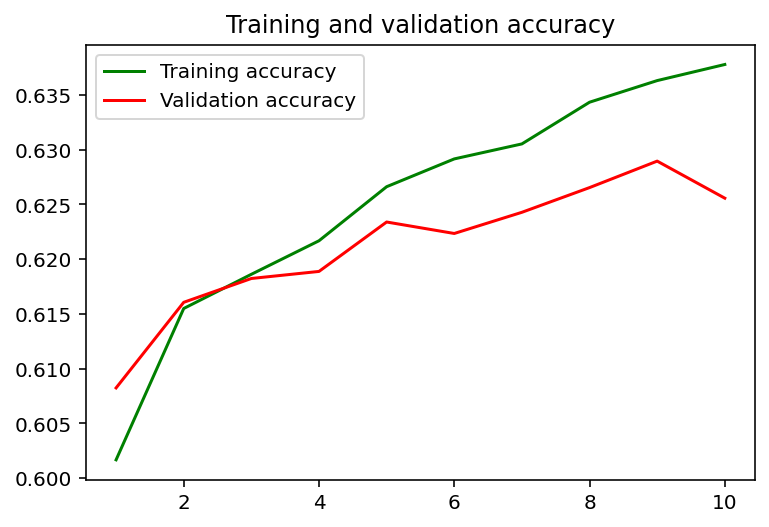

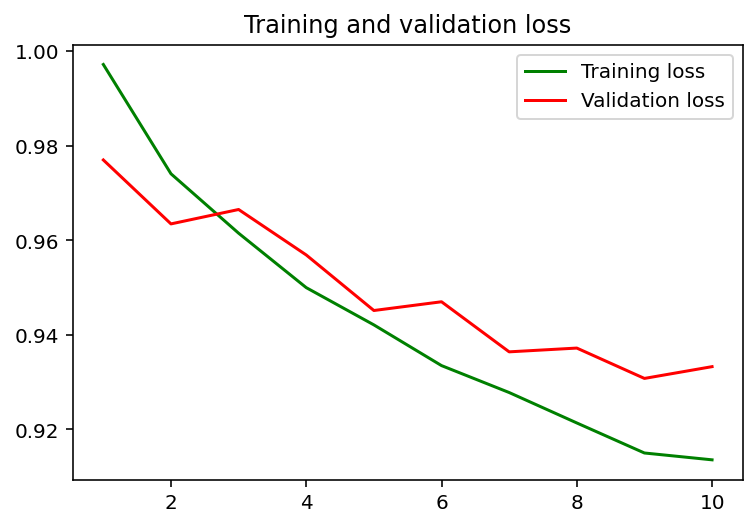

In [58]:
import matplotlib.pyplot as plt

accuracy = model_log.history['acc']
val_accuracy = model_log.history['val_acc']
loss = model_log.history['loss']
val_loss = model_log.history['val_loss']

epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [110]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["Neutral", "Happy", "Sad", "Love", "Anger"]

In [111]:
model_test = load_model('Checkpoint-0.6347.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [112]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     Neutral       0.45      0.42      0.43      1934
       Happy       0.70      0.69      0.69      4423
         Sad       0.56      0.66      0.60      2979
        Love       0.69      0.63      0.66      1707
       Anger       0.84      0.72      0.78      1360

    accuracy                           0.63     12403
   macro avg       0.65      0.62      0.63     12403
weighted avg       0.64      0.63      0.64     12403



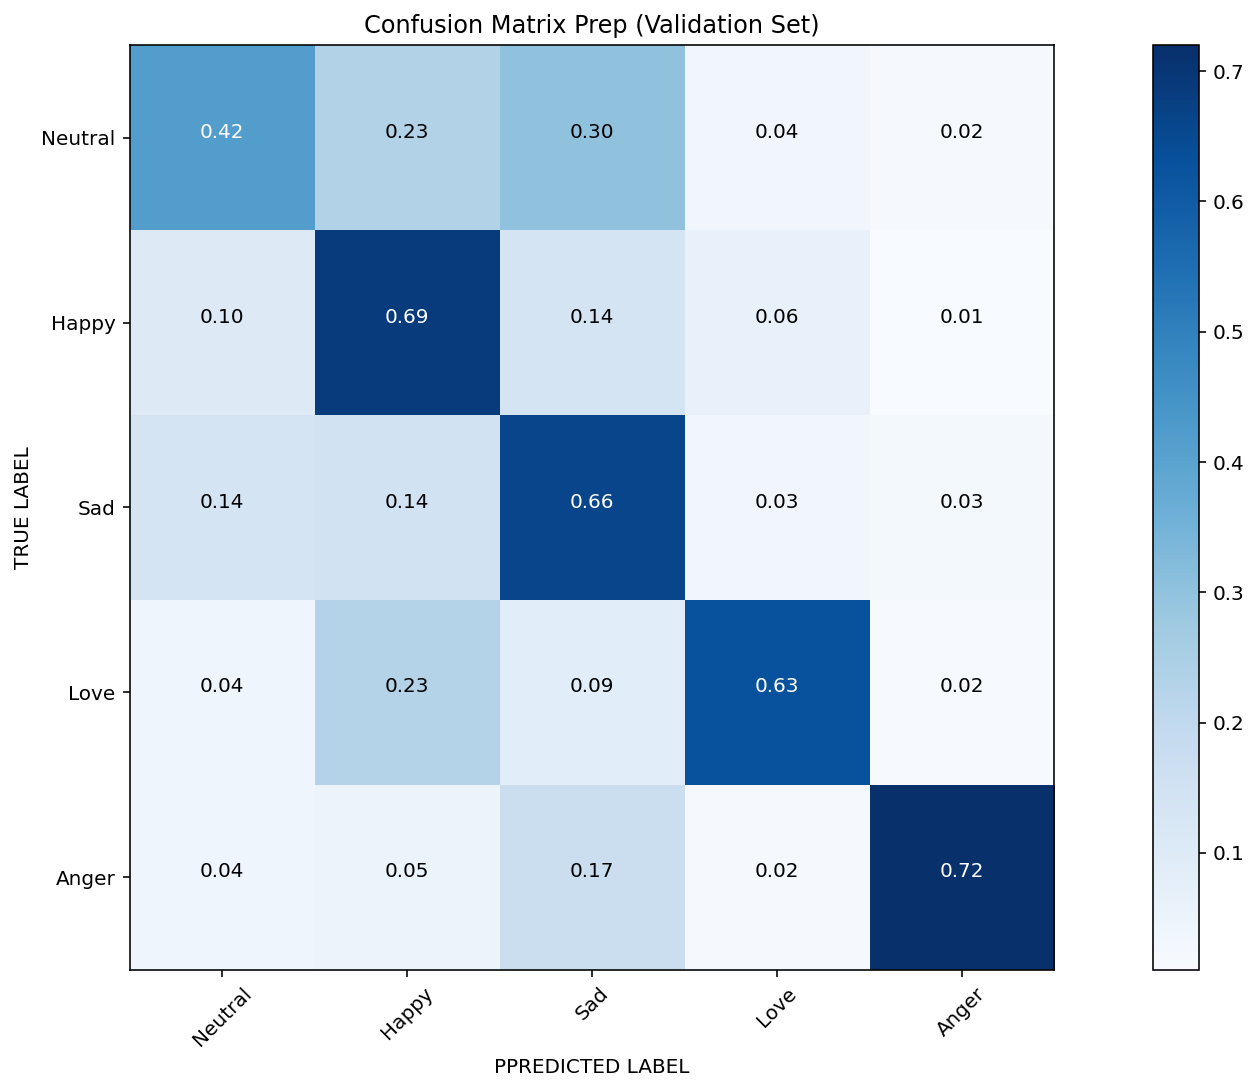

In [113]:
def plot_confusion_matrix(cm, labels, normalize=True, title='Confusion Matrix Prep (Validation Set)', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('TRUE LABEL')
    plt.xlabel('PPREDICTED LABEL')

plt.figure(figsize=(14,7.5))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [114]:
#Predicting emotions from paragraphs and sentences.

text = ["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "aarrgghh - fu*k.....a hose has leaked water all over the new floating floor", # anger
        "that b*tch is so ugly", # anger
        "oh no he is hospitalised!!!", # sad
       ]

In [115]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPREDICTION:",classes[pred],"\n")

For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find. 
PREDICTION: Love 

Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling. 
PREDICTION: Love 

One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between

In [116]:
np.array(sequences_test[2])

array([   56,    24,     1,    30,  1126,    11,     8,   474,    70,
          32,    13,     4,  2459,     1,   546,   290,   651,   158,
        1045,   274, 17373,    11,     3,  1298,     1,  1185,    43,
        1273,   387,     7,   119,    25,     4,  4672,    20,   190,
           1,   546,     3,  3659,    13,     4,  2163,   943,    13,
         104,     1,    50,     3,  1425,     6,   321,    15,    66,
          30,     4,  1298,     1,   272,  4612,     6,  4778,     3,
        1384,    11,     3,    13,    84,   689,     1,    30,    28,
           8,   356,    16,   539,    15,   431,    13,   125,    81,
         152,     2,  4000,     3,   104,   161,  2355,   301,   125,
           6,   807,   227,    20,  1109,   554,     2,   125])